# Particle spray algorithm by Chen et al. (2024) via `gala`

Author: Yingtian "Bill" Chen

We provide a notebook to generate streams using the Chen+24 ([arXiv:2408.01496](https://arxiv.org/abs/2408.01496)) model via `gala`. This implementation has been merged to the main branch of `gala` since version `v1.9`.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import astropy.units as u
import astropy.coordinates as coord

import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.dynamics.nbody import DirectNBody
from gala.units import galactic, UnitSystem

import pandas as pd

import h5py

#Reading GD1 data
df_desi = pd.read_csv('/Users/bsegovia/Downloads/brigette_code/GD-1/GD-1/All_table_at_fig4b_cleaned_copy.csv')


### Generate streams!

Here is the case of backward integration, which is more commonly used for stream modeling. But you can do forward integration by simply fliping the sign of `dt`.

Specifics on run() : [https://gala.adrian.pw/en/latest/api/gala.dynamics.mockstream.MockStreamGenerator.html#gala.dynamics.mockstream.MockStreamGenerator.run ] 

Specifics on nbody : 
[https://gala.adrian.pw/en/latest/dynamics/nbody.html ]

#### Calculate a more realistic radius of the perturber/subhalo

In [2]:
# CALCULATION for a more realistic radius of the perturber/subhalo 
# Defining constants 
c_o = 19.9 
a = [-0.195, 0.089, 0.089]
b = -0.54
x_sub = 1
rho_c = 8.5 * 10**(-27) * (u.kg/u.m**3) #kg/m^3
h = 0.7 #normalized hubble parameter 

m_200 = 1e7 * u.Msun # using only one value for now 

#Calculating r_200 
r_200 = (m_200 * (3/(4*np.pi))*(1/rho_c))**(1/3)

#Calculating c_200 
term = 0 
for i in range(len(a)):
    term +=   (a[i]*np.log(m_200 / (1e8 * h * u.Msun) ) )**i
c_200 = c_o * (1 + term) * (1 + b*np.log(x_sub))

#calculating radius of the perturber
r_s = r_200/c_200

c = r_s.to(u.pc)
c

<Quantity 722.26346645 pc>

#### Calculate the Escape Velocity
[https://docs.galpy.org/en/v1.7.2/reference/potentialhernquist.html] [https://gala.adrian.pw/en/latest/api/gala.potential.potential.HernquistPotential.html]

In [3]:
# Define parameters for the Plummer potential (progenitor)

perturber_mass = 5e7 * u.Msun

#calculating radius of the perturber
r_s = r_200/c_200
r = r_s.to(u.pc)  # Make sure it's in units compatible with your potential's normalization

# Initialize the Plummer potential for the progenitor
pert_pot_for_vesc = gp.HernquistPotential(m=perturber_mass, c=r_s.to(u.kpc) , units=galactic) #DM

# Convert position to galactic units (normalize by galactic scale)
r_dimensionless = (r / galactic['length']).decompose()

# Calculate the potential energy at radius r (3D position in dimensionless units)
potential_at_r = pert_pot_for_vesc.energy([r_dimensionless, 0, 0])

# Calculate escape velocity using v_esc = sqrt(-2 * Phi(r))
v_esc = np.sqrt(-2 * potential_at_r)

# Output escape velocity (in km/s)
print(f"Escape velocity at r = {r}: {v_esc.to(u.km/u.s)}")

Escape velocity at r = 722.26346645077 pc: [17.25510962] km / s


### Set up galactic potential and initial conditions of the progenitor and the perturber (DM subhalo)

Here, we use the `MWPotential2014` potential by Bovy (2015).

In [4]:
# pot = gp.BovyMWPotential2014(units=galactic)
pot = gp.CCompositePotential()
pot['hernquist'] = gp.HernquistPotential(m=0.6E10*u.Msun, c=0.7*u.kpc, units=galactic)
pot['MNdisk'] = gp.MiyamotoNagaiPotential(m=5E10*u.Msun, a=3*u.kpc, b=0.26*u.kpc, units=galactic)
pot['LSNFW'] = gp.LeeSutoTriaxialNFWPotential(v_c=220.*u.km/u.s, r_s=20.*u.kpc, a=1, b=1., c=0.87, units=galactic)

static_frame = gp.StaticFrame(galactic) #new addition
H = gp.Hamiltonian(potential=pot, frame=static_frame)


# Gaia coordinates of GD1 core IC in Standard Galactic Cartesian coordinates (from Koposov et al 2010):
prog_w0 = gd.PhaseSpacePosition(pos=[-3.41,13.00,9.58]*u.kpc,
                           vel=[-200.4,-162.6,13.9]*u.km/u.s)
prog_mass = 1e5 * u.Msun #monicas is 1e4 mine is 1e5


# #Define DM subhalo information
perturber_w0 = gd.PhaseSpacePosition(pos=[-4.41,13.00,9.58]*u.kpc,
                           vel=[-209.025,-162.6,13.9]*u.km/u.s) #-195.4 ; now using 1/2 of the calculated v_esc
perturber_mass = 5e7 * u.Msun

#Define the combined initial conditions
w0_combined = gd.combine((prog_w0, perturber_w0))

#### Calculate the Potential

In [5]:
#Potentials 
prog_pot = gp.PlummerPotential(m=prog_mass, b=4*u.pc, units=galactic) #progenitor monica uses b=.3*u.kpc
perturber_pot = gp.HernquistPotential(m=perturber_mass, c=r_s.to(u.kpc) , units=galactic) #DM

tot_pot = [prog_pot, perturber_pot]

In [6]:
perturber = gd.DirectNBody(perturber_w0, [perturber_pot], external_potential=pot)

In [7]:
df = ms.ChenStreamDF()
gen = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot) #there's no more arguments here

#nbody=nbody of DM because this is how many other objects can affect the stream

#release every 10 instead of 1 (monicas code uses 10)
stream, prog = gen.run(prog_w0=prog_w0, prog_mass=prog_mass, nbody=perturber, 
                                 release_every=5, n_particles=1, 
                                 output_every=True, output_filename='snapshot_files/snapshots', check_filesize=True, overwrite=True, 
                                 progress=False, dt=-5*u.Myr, n_steps=1000)#[source] #before was - 10 myr
                                                            # a value of 50000 n steps was taking over four minutes to run 

#release every 5, release particles every 5 time steps , n_particles is how many particles you release at every time step 
#A fixed timestep dt and a number of steps to run for (n_step). 


In [8]:
# maximum distance in x and y direction of the stream
stream_dx = stream.x.max()
stream_dy = stream.y.max()
print(f'The maximum distance in the x direction is {stream_dx} and in the y direction is {stream_dy}')

The maximum distance in the x direction is 10.07023291116783 kpc and in the y direction is 18.33331196919257 kpc


### Generate the movie!

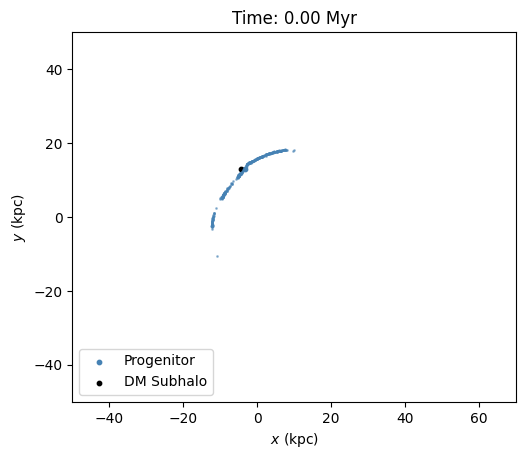

In [9]:

# Generate a movie using all_streams and all_progs
# Load the HDF5 file
with h5py.File('snapshot_files/snapshots', 'r') as f:
    # Load the position and time data for the progenitor and stream
    # prog_pos = f['nbody/pos'][:]  # Progenitor positions, shape (3, 501, 2)
    prog_pos = f['nbody/pos'][:,:,0]
    perturber_pos = f['nbody/pos'][:,:,1]
    stream_pos = f['stream/pos'][:]  # Stream positions, shape (3, 501, 1002)
    time_data = f['nbody/time'][:]  # Time steps, shape (501,)

# Create a figure for the animation
fig, ax = plt.subplots()

# Initialize scatter plots for progenitor and stream
prog_scatter = ax.scatter([], [], color='steelblue', s=10, alpha=1, label = 'Progenitor')
perturber_scatter = ax.scatter([], [], color='black', s=10, alpha=1, label = 'DM Subhalo')
stream_scatter = ax.scatter([], [], color='steelblue', s=1, alpha=0.5)

# Set plot labels and aspect ratio
ax.set_xlabel(r'$x\ ({\rm kpc})$')
ax.set_ylabel(r'$y\ ({\rm kpc})$')
ax.set_xlim(-11,11)
ax.set_ylim(-19,19)
ax.set_aspect(1)
ax.legend(loc='lower left')

# Set the limits for the x and y axes
ax.set_xlim(-50, 70) #(-50, 50)
ax.set_ylim(-50, 50) #(-50, 50)

# Update function for each frame in the animation
def update(frame):
    # Clear previous scatter points
    # prog_scatter.set_offsets(prog_pos[:2, frame, :].T)
    prog_scatter.set_offsets(prog_pos[:2, frame].T)
    perturber_scatter.set_offsets(perturber_pos[:2, frame].T)
    stream_scatter.set_offsets(stream_pos[:2, frame, :].T)

    ax.set_title(f"Time: {time_data[frame]:.2f} Myr")

# Create the animation
ani = FuncAnimation(fig, update, frames=len(time_data), interval=50)

# Save the animation as a video file
ani.save('movies/with_perturber_comp_pot_NEW_TEST.mp4', writer='ffmpeg')
# Show the plot
plt.show()

In [10]:
#used for color
stream_icrs_color = stream.to_coord_frame(coord.ICRS())
gd1_sim_color = stream_icrs_color.transform_to(gc.GD1Koposov10())


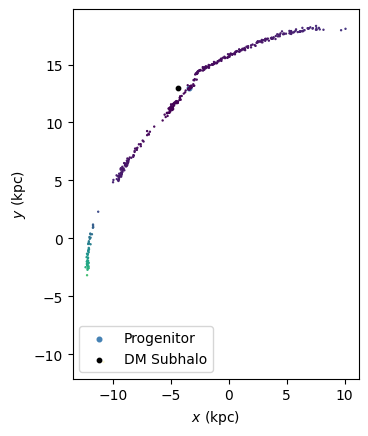

In [11]:
plt.scatter(prog.pos.x.value[0], prog.pos.y.value[0], color='steelblue', s=11, alpha=1, label = 'Progenitor')
plt.scatter(prog.pos.x.value[1], prog.pos.y.value[1], color='black', s=10, alpha=1, label = 'DM Subhalo')
plt.scatter(stream.pos.x.value, stream.pos.y.value, c=gd1_sim_color.radial_velocity.to_value('km/s'), s=0.5, alpha=1) #, label='With perturber')

plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
# plt.xlim(-25, 50)
# plt.ylim(-20, 30)
plt.legend(loc='lower left')
plt.gca().set_aspect(1)
plt.show()

In [12]:
stream_icrs = stream.to_coord_frame(coord.ICRS())
prog_icrs = prog.to_coord_frame(coord.ICRS())
stream_gc = stream.to_coord_frame(coord.Galactic())
prog_gc = stream.to_coord_frame(coord.Galactic())

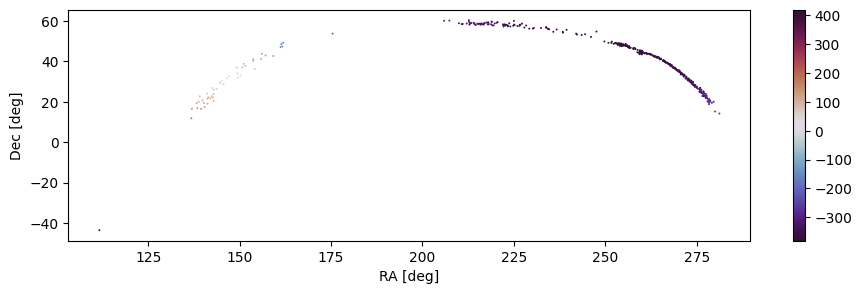

In [13]:
# ------- Figure object --------------------------------------------------------
fig = plt.figure()
fig.set_figheight(3) 
fig.set_figwidth(11)
plt.subplot(111)
cs = plt.scatter(
    stream_icrs.ra.degree,
    stream_icrs.dec.degree,
    marker='o', linewidth=0, s=2, 
    c=stream_icrs.radial_velocity.value, cmap='twilight_shifted')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.colorbar(cs)
#plt.colorbar(cs)
# plt.savefig('trial_stream_cart.png')


In [14]:
phi1 = df_desi['phi_1'] * u.rad
phi2 = df_desi['phi_2'] * u.rad

gd1_sim = stream_icrs.transform_to(gc.GD1Koposov10())

/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_4670/3045742203.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1=ax.scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b',label='Observed')


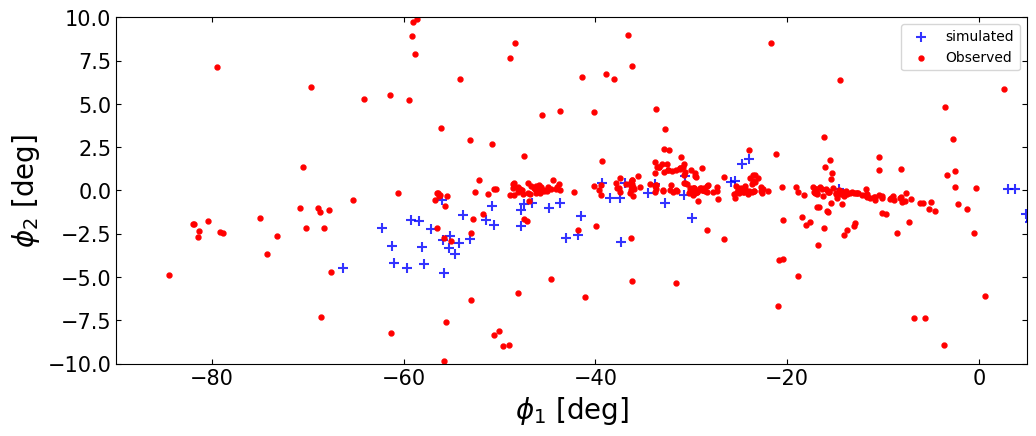

In [15]:
#sample  scatter plot:
# ------- Figure object
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(11)
    
# ------- Axis object
ax = plt.subplot(1,1,1)
ax.tick_params(axis='both',which='both',direction='in',
                   labelsize=15,right=True,top=True)
#ax.xaxis.set_ticks(np.arange(-400,400, step=100.))
#ax.yaxis.set_ticks(np.arange(-400,400, step=100.))
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)

#ax.set_xlim(-420.,420.)

ax.set_ylim(-10.,10.)
ax.set_xlim(-90, 5.)
ax.scatter(gd1_sim.phi1, gd1_sim.phi2, marker='+', s=50,color='blue', alpha = 0.8, label='simulated')
#c=gd1sim_dvel.to_value(u.km / u.s)

# ------- Plot
sc1=ax.scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b',label='Observed') 

ax.legend()
ax.grid(False)



ax.grid(False)
fig.tight_layout(pad=3.0)
plt.savefig('phi1_phi2_plots/GD1_sim_dat_with_perturber_comp_pot.png')
plt.show()
plt.close()

## Looking at Mass Loss of Perturber Over Time


In [16]:
############################################################################################################

pot = gp.CCompositePotential()
pot['hernquist'] = gp.HernquistPotential(m=0.6E10*u.Msun, c=0.7*u.kpc, units=galactic)
pot['MNdisk'] = gp.MiyamotoNagaiPotential(m=5E10*u.Msun, a=3*u.kpc, b=0.26*u.kpc, units=galactic)
pot['LSNFW'] = gp.LeeSutoTriaxialNFWPotential(v_c=220.*u.km/u.s, r_s=20.*u.kpc, a=1, b=1., c=0.87, units=galactic)

static_frame = gp.StaticFrame(galactic) #new addition
H = gp.Hamiltonian(potential=pot, frame=static_frame)


# Gaia coordinates of GD1 core IC in Standard Galactic Cartesian coordinates (from Koposov et al 2010):
prog_w0 = gd.PhaseSpacePosition(pos=[-3.41,13.00,9.58]*u.kpc,
                           vel=[-200.4,-162.6,13.9]*u.km/u.s)
prog_mass = 1e5 * u.Msun #monicas is 1e4 mine is 1e5


# #Define DM subhalo information
perturber_w0 = gd.PhaseSpacePosition(pos=[-4.41,13.00,9.58]*u.kpc,
                           vel=[-195.4,-162.6,13.9]*u.km/u.s)
perturber_mass = 1e6 * u.Msun

#Define the combined initial conditions
w0_combined = gd.combine((prog_w0, perturber_w0))


############################################################################################################

# CALCULATION for a more realistic radius of the perturber/subhalo 
# Defining constants 
c_o = 19.9 
a = [-0.195, 0.089, 0.089]
b = -0.54
x_sub = 1
rho_c = 8.5 * 10**(-27) * (u.kg/u.m**3) #kg/m^3
h = 0.7 #normalized hubble parameter 

m_200 = 1e7 * u.Msun # using only one value for now 

#Calculating r_200 
r_200 = (m_200 * (3/(4*np.pi))*(1/rho_c))**(1/3)

#Calculating c_200 
term = 0 
for i in range(len(a)):
    term +=   (a[i]*np.log(m_200 / (1e8 * h * u.Msun) ) )**i
c_200 = c_o * (1 + term) * (1 + b*np.log(x_sub))

#calculating radius of the perturber
r_s = r_200/c_200

c = r_s.to(u.pc)

############################################################################################################
#Potentials 
prog_pot = gp.PlummerPotential(m=prog_mass, b=4*u.pc, units=galactic) #progenitor monica uses b=.3*u.kpc
#The perturber is represented by a Hernquist (1990) sphere of mass  5×106 Me and scale radius 10 pc. 
#Its closest approach to GD-1 happened 495 Myr ago with a relative distance of 15 pc,
perturber_pot = gp.HernquistPotential(m=perturber_mass, c=r_s.to(u.kpc) , units=galactic) #DM

tot_pot = [prog_pot, perturber_pot]

perturber = gd.DirectNBody(perturber_w0, [perturber_pot], external_potential=pot)


pot = gp.CCompositePotential()
pot['hernquist'] = gp.HernquistPotential(m=0.6E10*u.Msun, c=0.7*u.kpc, units=galactic)
pot['MNdisk'] = gp.MiyamotoNagaiPotential(m=5E10*u.Msun, a=3*u.kpc, b=0.26*u.kpc, units=galactic)
pot['LSNFW'] = gp.LeeSutoTriaxialNFWPotential(v_c=220.*u.km/u.s, r_s=20.*u.kpc, a=1, b=1., c=0.87, units=galactic)

static_frame = gp.StaticFrame(galactic) #new addition
H = gp.Hamiltonian(potential=pot, frame=static_frame)


# Gaia coordinates of GD1 core IC in Standard Galactic Cartesian coordinates (from Koposov et al 2010):
prog_w0 = gd.PhaseSpacePosition(pos=[-3.41,13.00,9.58]*u.kpc,
                           vel=[-200.4,-162.6,13.9]*u.km/u.s)
prog_mass = 1e5 * u.Msun #monicas is 1e4 mine is 1e5


# #Define DM subhalo information
perturber_w0 = gd.PhaseSpacePosition(pos=[-4.41,13.00,9.58]*u.kpc,
                           vel=[-209.025,-162.6,13.9]*u.km/u.s) #-195.4 ; now using 1/2 of the calculated v_esc
perturber_mass = 5e7 * u.Msun

#Define the combined initial conditions
w0_combined = gd.combine((prog_w0, perturber_w0))

In [17]:
#easy way to save 10 % 
#run the function for the full time step, then save the values at the pericenter 
# and then run the function again everytime that there is a pericenter, with the exact values of position and velocity BUT only using 10 percent of the initial mass
# of the progenitor 

stream_dist_to_center = np.sqrt(stream.pos.x**2 + stream.pos.y**2 + stream.pos.z**2)
abs_min_dist = np.min(stream_dist_to_center)

# Calculate the derivative of y with respect to time
dy_dt = np.gradient(stream.pos.y.value)

# Find indices where the stream crosses the x-axis with a positive slope
# Get half of the stream, multiply it by the other half, and if it is negative, then it crossed the x-axis
# with a positive slope
crossing_indices = np.where((stream.pos.y.value[:-1] * stream.pos.y.value[1:] < 0) & (dy_dt[1:] > 0))[0]

#The number of upward crossings is equal to the number of orbits
num_orbits = len(crossing_indices)  

print(f"The stream completes {num_orbits} orbits over the given time period.")

The stream completes 45 orbits over the given time period.


In [18]:
dt_array = np.linspace(-5, 0, num_orbits) * u.Myr
n_steps__temp = np.ones(num_orbits) * 1000
n_steps_function = - n_steps__temp / dt_array.value
n_steps_function[-1] = n_steps_function[-2]
n_steps_function

/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_4670/2605715626.py:3: RuntimeWarning: divide by zero encountered in divide
  n_steps_function = - n_steps__temp / dt_array.value


array([ 200.        ,  204.65116279,  209.52380952,  214.63414634,
        220.        ,  225.64102564,  231.57894737,  237.83783784,
        244.44444444,  251.42857143,  258.82352941,  266.66666667,
        275.        ,  283.87096774,  293.33333333,  303.44827586,
        314.28571429,  325.92592593,  338.46153846,  352.        ,
        366.66666667,  382.60869565,  400.        ,  419.04761905,
        440.        ,  463.15789474,  488.88888889,  517.64705882,
        550.        ,  586.66666667,  628.57142857,  676.92307692,
        733.33333333,  800.        ,  880.        ,  977.77777778,
       1100.        , 1257.14285714, 1466.66666667, 1760.        ,
       2200.        , 2933.33333333, 4400.        , 8800.        ,
       8800.        ])

In [19]:
#easy way to save 10 % 
#run the function for the full time step, then save the values at the pericenter 
# and then run the function again everytime that there is a pericenter, with the exact values of position and velocity BUT only using 10 percent of the initial mass
# of the progenitor 

stream_dist_to_center = np.sqrt(stream.pos.x**2 + stream.pos.y**2 + stream.pos.z**2)
abs_min_dist = np.min(stream_dist_to_center)

# Calculate the derivative of y with respect to time
dy_dt = np.gradient(stream.pos.y.value)

# Find indices where the stream crosses the x-axis with a positive slope
# Get half of the stream, multiply it by the other half, and if it is negative, then it crossed the x-axis
# with a positive slope
crossing_indices = np.where((stream.pos.y.value[:-1] * stream.pos.y.value[1:] < 0) & (dy_dt[1:] > 0))[0]

#The number of upward crossings is equal to the number of orbits
num_orbits = len(crossing_indices)  

print(f"The stream completes {num_orbits} orbits over the given time period.")

# Identify the minimum values for abs_min_dist in each orbit
# Lists to store the indices and values of minimum distances for each orbit
orbit_min_indices = []
orbit_min_values = []
for i in range(len(crossing_indices) // 2):
    # Define the range for each orbit
    # In crossing_indices, every two consecutive indices represent one full orbit
    orbit_start = crossing_indices[2 * i] #this should index the beginning of the orbit
    orbit_end = crossing_indices[2 * i + 1] #this should index the end of the orbit
    
    # Find the minimum value within this orbit range
    orbit_min_index = np.argmin(stream_dist_to_center[orbit_start:orbit_end]) + orbit_start
    orbit_min_indices.append(orbit_min_index)
    orbit_min_values.append(stream_dist_to_center[orbit_min_index])

# Print the indices and values of the minimum values for each orbit
print(f"Indices of minimum distance (pericenter) for each orbit: {orbit_min_indices}")
print(f"Values of minimum distances for each orbit: {orbit_min_values}")

#time step is defined by the number of orbits
dt_array = np.linspace(-5, 0, num_orbits) * u.Myr
n_steps__temp = np.ones(num_orbits) * 1000
n_steps_function = - n_steps__temp / dt_array.value
n_steps_function[-1] = n_steps_function[-2]


def run_simulation_with_restarts(prog_w0, prog_mass, perturber, H, prog_pot, dt, min_indices, n_steps):
    all_streams = []
    all_progs = []
    
    # Start with the initial progenitor and perturber positions/velocities
    current_prog_pos = prog_w0.pos
    current_prog_vel = prog_w0.vel
    current_perturber_pos = prog_w0.pos
    current_perturber_vel = prog_w0.vel
    
    for i in range(len(dt_array)):
        # Adjust progenitor mass for this run
        current_pert_mass = perturber_mass * (0.9 ** i)
        
        # Update initial conditions for the next run using the last positions and velocities
        prog_w0 = gd.PhaseSpacePosition(pos=current_prog_pos, vel=current_prog_vel)
        perturber_w0 = gd.PhaseSpacePosition(pos=current_perturber_pos,
                           vel=current_perturber_vel)
        
        #Recalculate the potential with the new progenitor mass, and both the new pos and vel for the prog. and pert. 

        # Run the simulation
        stream, prog = gen.run(prog_w0=prog_w0, prog_mass=prog_mass, nbody=perturber, 
                               release_every=5, n_particles=1, 
                               output_every=True, output_filename=f'snapshot_files/snapshots_UsingFulldt_{i}', 
                               check_filesize=True, overwrite=True, 
                               progress=False, t1 = dt_array[i], t2=dt_array[i+1], n_steps=n_steps[i])
                                               #t2 is end , t1 is start t1=dt_array[i], t2=dt_array[i+1]
        # Store the results
        all_streams.append(stream)
        all_progs.append(prog)
        

        current_prog_pos = prog.pos.xyz[:,0]  
        current_prog_vel = prog.v_xyz[:,0] 
        current_perturber_pos = prog.pos.xyz[:,1] 
        current_perturber_vel = prog.v_xyz[:,1] 
    
    return all_streams, all_progs


## ISSUES : The dispersion of the particle is not saved, only the progenitor location is saved, so when movie is restarted, it assumes the stream is less disrupted. 
#progenitor is taking the position of the DM subhalo, so it is not being updated.
## ISSUES : The 

# Run the simulation with restarts
all_streams, all_progs = run_simulation_with_restarts(prog_w0, prog_mass, perturber, H, prog_pot, dt_array, orbit_min_indices, n_steps_function)

#takes almost two mins to run with previous conditions 

/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_4670/3272279656.py:44: RuntimeWarning: divide by zero encountered in divide
  n_steps_function = - n_steps__temp / dt_array.value


The stream completes 45 orbits over the given time period.
Indices of minimum distance (pericenter) for each orbit: [3, 8, 16, 18, 22, 26, 30, 36, 39, 47, 50, 57, 61, 71, 73, 78, 84, 89, 98, 105, 114, 117]
Values of minimum distances for each orbit: [<Quantity 13.05282313 kpc>, <Quantity 19.9018501 kpc>, <Quantity 20.29826436 kpc>, <Quantity 20.39686264 kpc>, <Quantity 19.4341416 kpc>, <Quantity 19.1064231 kpc>, <Quantity 19.48672893 kpc>, <Quantity 19.80680153 kpc>, <Quantity 13.08937482 kpc>, <Quantity 13.10255257 kpc>, <Quantity 19.09892861 kpc>, <Quantity 12.9857719 kpc>, <Quantity 13.03298191 kpc>, <Quantity 13.20482924 kpc>, <Quantity 12.98471404 kpc>, <Quantity 18.97025759 kpc>, <Quantity 19.60445895 kpc>, <Quantity 13.2540366 kpc>, <Quantity 18.99755198 kpc>, <Quantity 13.03472427 kpc>, <Quantity 19.06431048 kpc>, <Quantity 13.22210484 kpc>]


KeyboardInterrupt: 

In [ ]:
# Initialize lists to hold the compiled data from all snapshots
all_prog_pos = []
all_perturber_pos = []
all_stream_pos = []
all_time_data = []

# Iterate over the snapshot files generated
for i in range(len(orbit_min_indices)):  # Replace with actual snapshot count if known
    snapshot_file = f'snapshot_files/snapshots_{i}'
    
    with h5py.File(snapshot_file, 'r') as f:
        # Load the positions and time data for each snapshot
        prog_pos = f['nbody/pos'][:, :, 0]
        perturber_pos = f['nbody/pos'][:, :, 1]
        stream_pos = f['stream/pos'][:]
        time_data = f['nbody/time'][:]
        
        # Append data from this snapshot to the lists
        all_prog_pos.append(prog_pos)
        all_perturber_pos.append(perturber_pos)
        all_stream_pos.append(stream_pos)
        all_time_data.append(time_data)

# Concatenate all the data along the time axis
all_prog_pos = np.concatenate(all_prog_pos, axis=1)
all_perturber_pos = np.concatenate(all_perturber_pos, axis=1)
all_stream_pos = np.concatenate(all_stream_pos, axis=1)
all_time_data = np.concatenate(all_time_data)

# Create the figure for the animation
fig, ax = plt.subplots()

# Initialize scatter plots for progenitor, perturber, and stream
prog_scatter = ax.scatter([], [], color='steelblue', s=10, alpha=1, label='Progenitor')
perturber_scatter = ax.scatter([], [], color='black', s=10, alpha=1, label='DM Subhalo')
stream_scatter = ax.scatter([], [], color='steelblue', s=1, alpha=0.5)

# Set plot labels and aspect ratio
ax.set_xlabel(r'$x\ ({\rm kpc})$')
ax.set_ylabel(r'$y\ ({\rm kpc})$')
ax.set_aspect(1)
ax.legend(loc='lower left')

# Set the limits for the x and y axes
ax.set_xlim(-50, 70)
ax.set_ylim(-50, 50)

# Update function for each frame in the animation
def update(frame):
    # Update scatter points for progenitor, perturber, and stream
    prog_scatter.set_offsets(all_prog_pos[:2, frame].T)
    perturber_scatter.set_offsets(all_perturber_pos[:2, frame].T)
    stream_scatter.set_offsets(all_stream_pos[:2, frame].T)
    
    # Update the title with the current time
    ax.set_title(f"Time: {all_time_data[frame]:.2f} Myr")

# Create the animation
ani = FuncAnimation(fig, update, frames=len(all_time_data), interval=50)

# Save the animation as a video file
ani.save('movies/compiled_simulation_with_perturber.mp4', writer='ffmpeg')

# Show the plot
plt.show()


#Takes almost 3 minutes to run 

#
#
#
#
#
#
#
#